# Clustering Case Study: Customer Segmentation with K-Means -  Tier 3

<div style="text-align: right"><i><font size="2"> by: <a href="https://www.linkedin.com/in/sonjoy-das-9b323213/" target="_parent">Sonjoy Das, PhD</a></font></i></div>

***

Structure of the mini-project:

1. **Sourcing and loading**
    * Load the data
    * Explore the data


2. **Cleaning, transforming and visualizing**
    * Data Wrangling: Exercise Set 1
        - Creating a matrix with a binary indicator for whether they responded to a given offer
        - Ensure that in doing so, NAN values are dealt with appropriately
    

3. **Modelling** 
    * K-Means clustering: Exercise Sets 2 and 3
        - Choosing K: The Elbow method
        - Choosing K: The Silhouette method
        - Choosing K: The Gap statistic method
    
    * Visualizing clusters with PCA: Exercise Sets 4 and 5


4. **Conclusions and next steps**
    * Conclusions
    * Other clustering algorithms (Exercise Set 6)

In [1]:
%matplotlib inline
import pandas as pd
# import sklearn
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

# For PCA
import numpy as np

# For the Silhouette Method
import matplotlib.cm as cm

# For Section 3b. Visualizing Clusters using PCA
import matplotlib.colors
 

## 1. Sourcing and loading
### 1a. Load the data
The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [2]:
df_offers = pd.read_excel('./WineKMC.xlsx', sheet_name=0)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


### 1b. Explore the data

In [3]:
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [4]:
df_transactions = pd.read_excel('./WineKMC.xlsx', sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## 2. Cleaning, transforming and visualizing
### 2a. Data Wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [5]:
# Calling merge() on df_transactions and df_offers
merged = df_transactions.merge(df_offers, how='left', on='offer_id')

merged

,customer_name,offer_id,n,campaign,varietal,min_qty,discount,origin,past_peak
0,Smith,2,1,January,Pinot Noir,72,17,France,False
1,Smith,24,1,September,Pinot Noir,6,34,Italy,False
2,Johnson,17,1,July,Pinot Noir,12,47,Germany,False
3,Johnson,24,1,September,Pinot Noir,6,34,Italy,False
4,Johnson,26,1,October,Pinot Noir,144,83,Australia,False
...,...,...,...,...,...,...,...,...,...
319,Fisher,11,1,May,Champagne,72,85,France,False
320,Fisher,22,1,August,Champagne,72,63,France,False
321,Fisher,28,1,November,Cabernet Sauvignon,12,56,France,True
322,Fisher,30,1,December,Malbec,6,54,France,False


In [6]:
# Make a pivot table
pivoted = pd.pivot_table(merged,index='customer_name', columns='offer_id', values='n', fill_value=0)

pivoted

offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
Allen,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
Anderson,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
Bailey,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
Baker,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Williams,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
Wilson,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
Wood,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


## 3. Modelling 
### 3a. K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

#### 3ai. Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

**Hint:** the Elbow Method is discussed in part 2 of the Harvard Clustering lecture. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

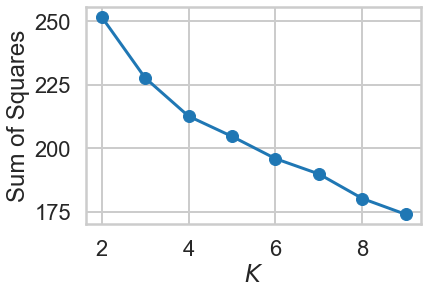

In [7]:
# Make an empty list
sum_of_squares = []

# Make an empty dictionary called assignments 
clusters = {}

# Cast your table 'pivoted' as a matrix with to_numpy(), and store it in a variable X 
X = pivoted.to_numpy()

# Make a variable called Krange, and assign it a list of range(2, 10)
Krange  = list(range(2, 10))

# We now want to iterate through this list to construct a plot showing SS for each K. Name the iterator variable K 
for K in Krange:
    # Make a variable called model, and assign it the result of calling sklearn.cluster.KMeans, with n_clusters = K 
    kmeans = KMeans(n_clusters=K,random_state = 100)
    cluster_label = kmeans.fit_predict(X)
    centers = kmeans.cluster_centers_
    sum_of_squares.append(np.sum((X - centers[cluster_label]) ** 2))
    clusters[str(K)] = cluster_label

# Call plot() on plt with parameters Krange and ss
plt.plot(Krange, sum_of_squares,'o-')

# Let's label the plot 
plt.xlabel("$K$")
plt.ylabel("Sum of Squares");


__(Elbow method). From the plot, it seems that $K = 3$ will possibly be the best choice because the sum-of-squares plot vs $K$ is reducing very slowly after $K = 3$.__ However, if the `random_state = 100` is changed, then this plot will look slightly different. You can test it by running the code for different values of `random_state`. In general (not necessarily for this particular value of `random_state = 100`), the values of sum-of-squares for this problem is found to change smoothly as $K$ is increased. In such cases, there is not really any optimial way to choose K based on distinct clusters because the plot above implies that there is not really a set of distinct clusters. Therefore, one might like to choose a certain threshold value for sum-of-squares to find a $K$. Once that threshold value is reached for a particular value of $K$, we can choose that $K$. In this case, let us choose $K = 3$.

The number of clusters is 3.


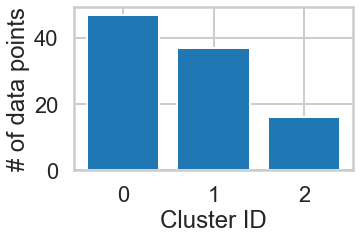

In [8]:
# What is the best K? Fill in the assignment below appropriately
best_K = 3
cluster_best_K = clusters[str(best_K)]
counts = np.bincount(cluster_best_K)
print(f"The number of clusters is {len(counts)}.")

# Call bar() on plt, with parameters range(best_K), counts, and align = 'center'
figClusterDataPoints = plt.figure(figsize=(5, 3))
plt.bar(range(best_K),counts,align = 'center')

# Label the axes 
plt.xlabel("Cluster ID")
plt.ylabel("# of data points")
plt.xticks(range(best_K));

##### __Project the Data to the First Two Dominant Principal Components using PCA for Visualization__

In [9]:
pca2 = PCA(n_components=2)
 
#Transform the data
df_pca2 = pca2.fit_transform(X)
df_pca2.shape

(100, 2)

In [10]:
#Initialize the class object
kmeans = KMeans(n_clusters= best_K,random_state = 100)
 
#predict the labels of clusters.
cluster_labels = kmeans.fit_predict(df_pca2)
pd.value_counts(cluster_labels)

0    47
1    37
2    16
dtype: int64

##### __Plotting Two of the K-Means Clusters__

In [11]:
# filter rows of pca data
# filtered_label0 = df_pca2[cluster_labels == 0]
 
# filtered_label2 = df_pca2[cluster_labels == 2]
 
# #Plotting the results
# plt.figure(figsize=(10, 8))
# plt.scatter(filtered_label0[:,0] , filtered_label0[:,1] , color='red', marker='^', alpha=0.5, label = 'cluster 0')
# plt.scatter(filtered_label2[:,0] , filtered_label2[:,1] , color='black', alpha=0.5, label = 'cluster 2')
# plt.legend()
# plt.xlabel("PC 1")
# plt.ylabel("PC 2")

# plt.show()

##### __Plot All K-Means Clusters__

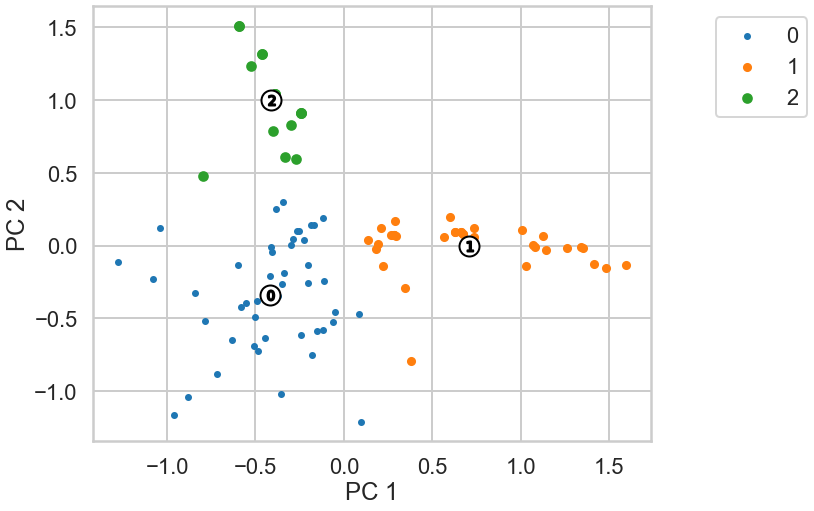

In [12]:
#Getting unique labels
 
u_labels = np.unique(cluster_labels)
 
#plotting the results:

plt.figure(figsize=(10, 8))
for i in u_labels:
    plt.scatter(df_pca2[cluster_labels == i , 0] , df_pca2[cluster_labels == i , 1] , s=25*(i+1), label = i)

plt.legend(bbox_to_anchor=(1, 0.8, 0.3, 0.2))

# Labeling the clusters
centers = kmeans.cluster_centers_
# Draw white circles at cluster centers
plt.scatter(centers[:, 0], centers[:, 1], 
            marker="o", c="white", alpha=1, s=400, edgecolor="k")

for i, c in enumerate(centers):
    plt.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=100, edgecolor="k")
    
plt.xlabel("PC 1")
plt.ylabel("PC 2")

plt.show()

__From the PCA-based cluster plot above, a strong cluster structure is not really obvious.__ This visual observation is consistent with what we found in the context of sum-of-squares vs $K$ plot (Elbow method).

#### 3aii. Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

**Hint**: Scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

For n_clusters = 2, The average silhouette_score is : 0.07926723462002187
For n_clusters = 3, The average silhouette_score is : 0.12133064283950247
For n_clusters = 4, The average silhouette_score is : 0.1248486484988946
For n_clusters = 5, The average silhouette_score is : 0.10164181050101599
For n_clusters = 6, The average silhouette_score is : 0.11634582083908686
For n_clusters = 7, The average silhouette_score is : 0.1287807502795386
For n_clusters = 8, The average silhouette_score is : 0.11693615872038611
For n_clusters = 9, The average silhouette_score is : 0.10864094827857868


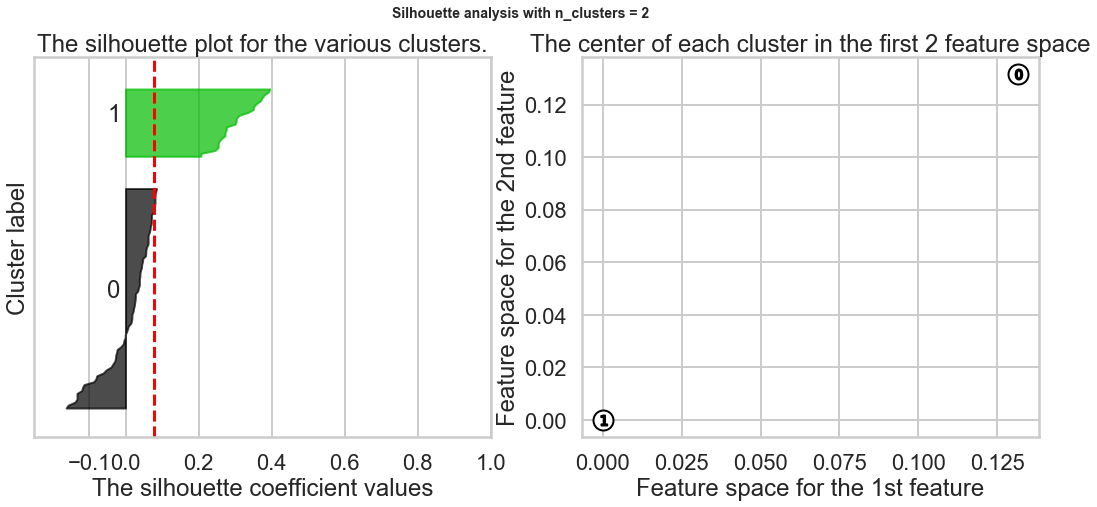

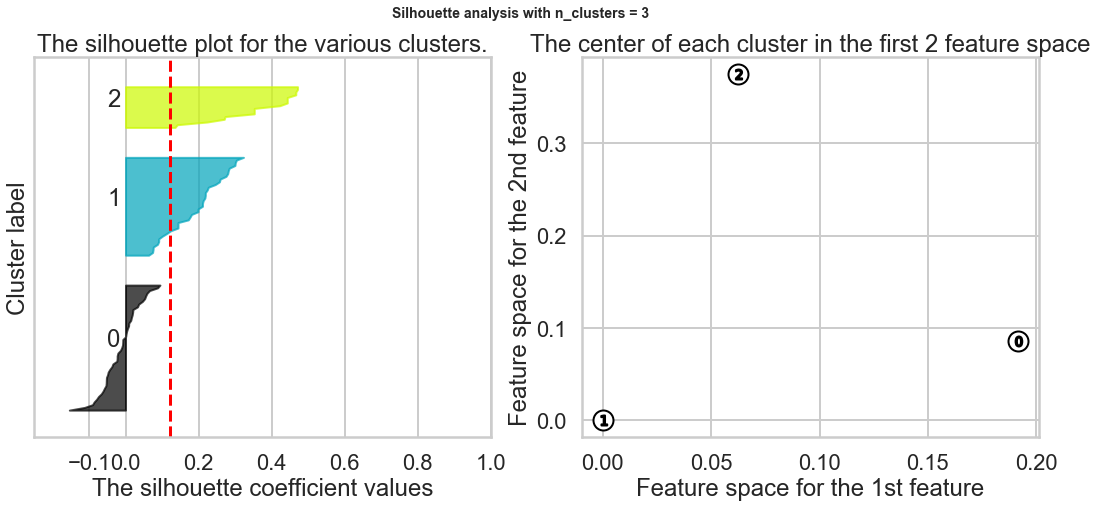

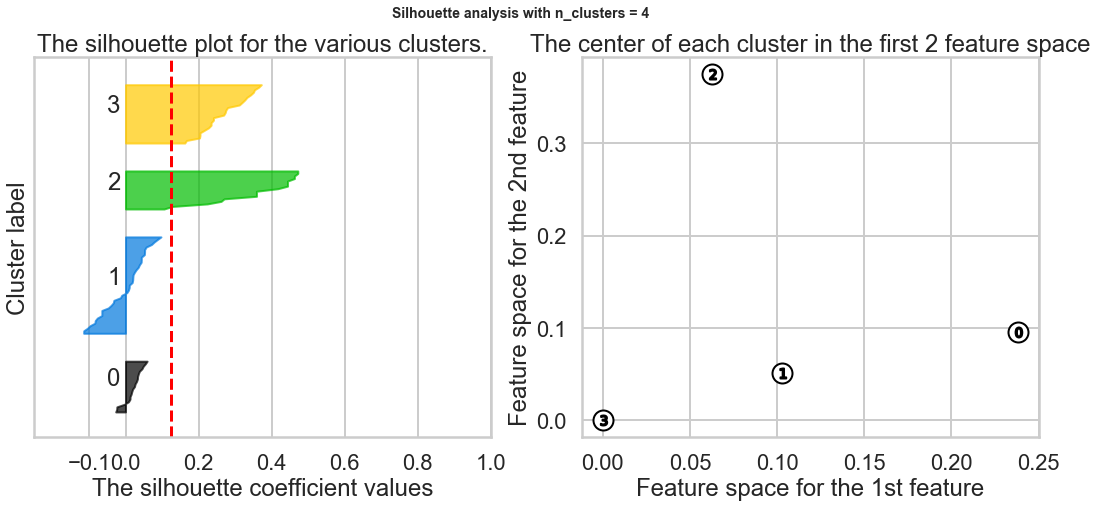

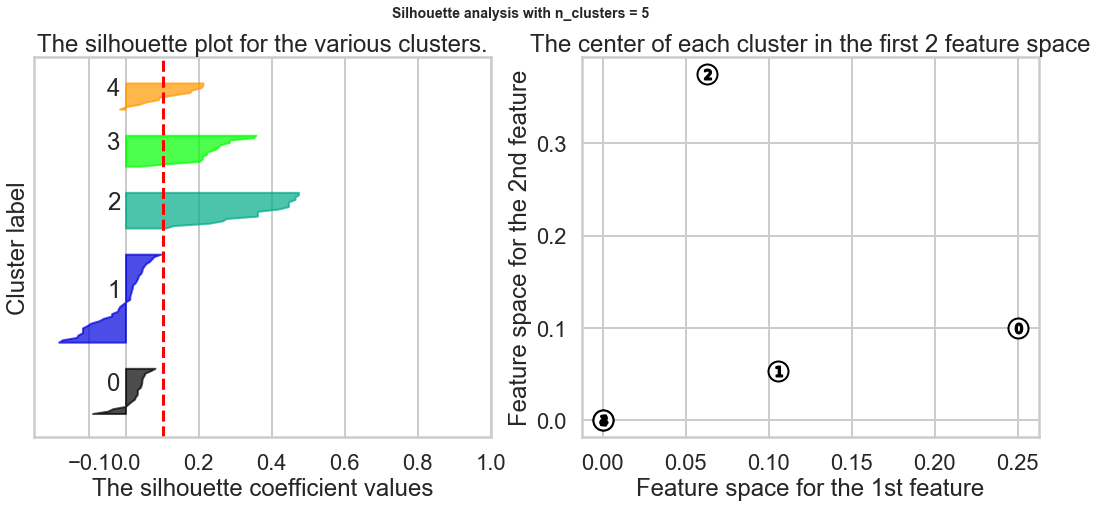

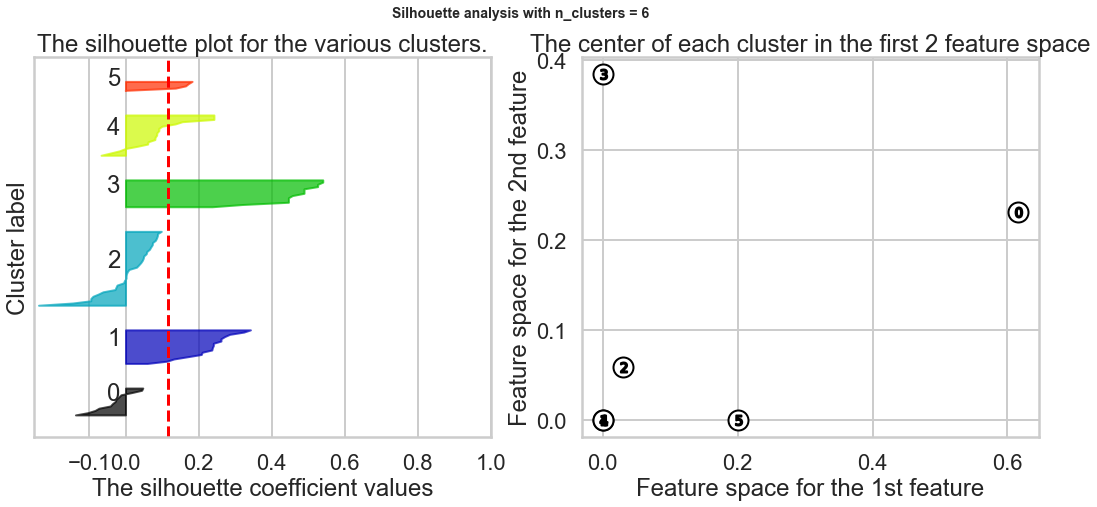

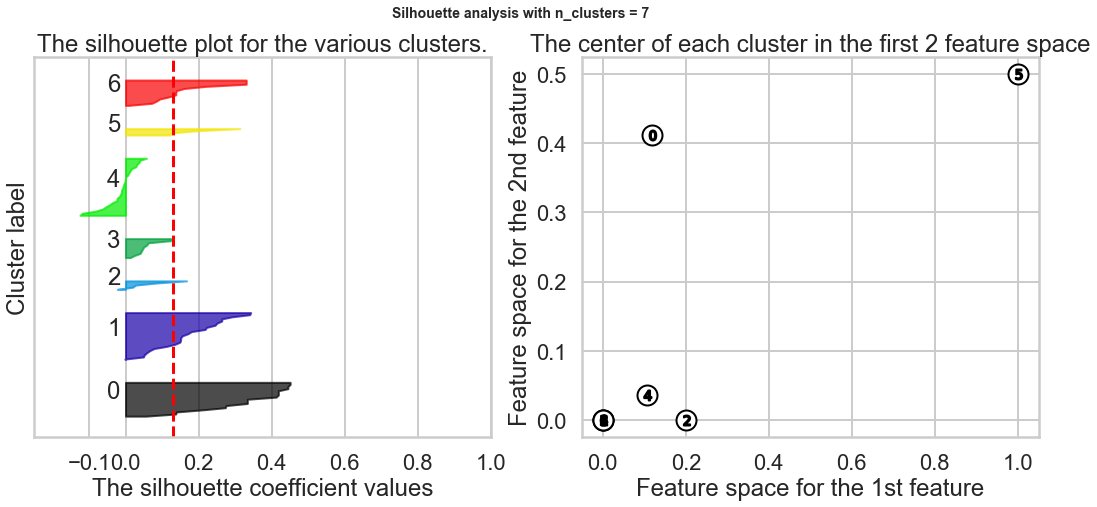

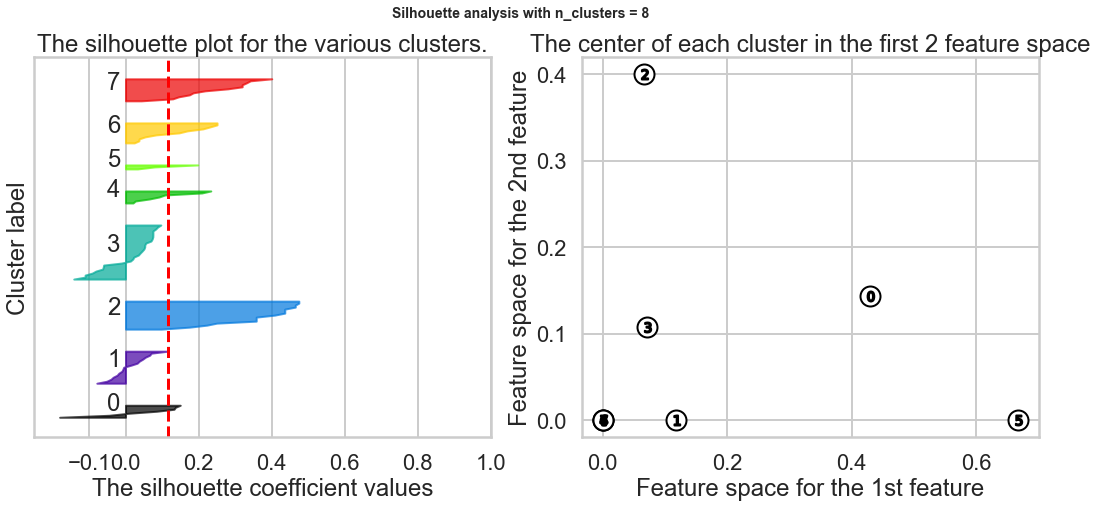

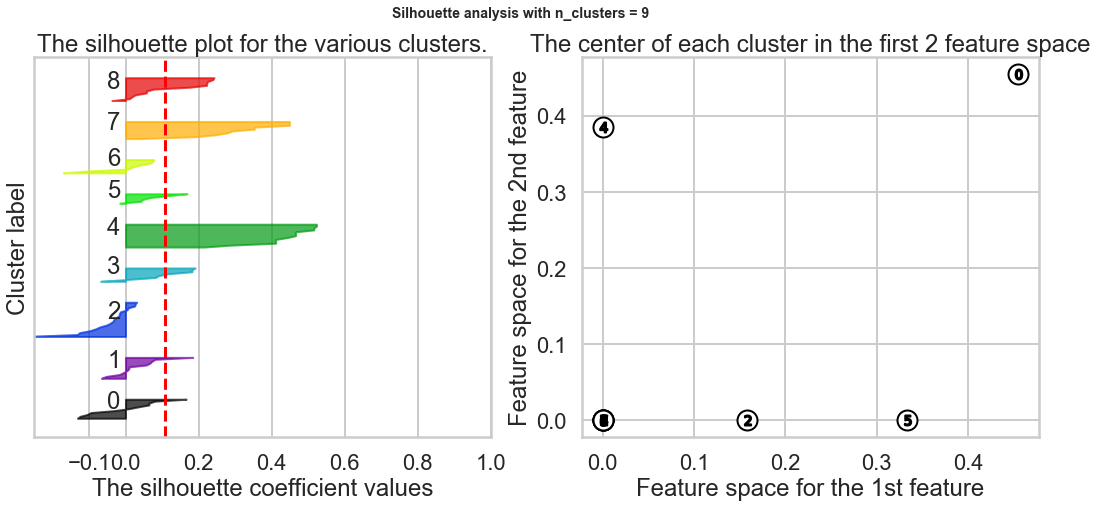

In [13]:
# SOURCE: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

# import sklearn.metrics
# import matplotlib.cm as cm

# Make an empty list called avg_silhouette_scores
avg_silhouette_scores = []

# Iterate through Krange with variable K as before
for K in Krange:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
#     fig, ax1 = plt.subplots(1, 1)
#     fig.set_size_inches(9, 5)


    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    # Call set_xlim on ax1 
    ax1.set_xlim([-0.25, 1])
    # The (K+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (K + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 100 for reproducibility.
    kmeans = KMeans(n_clusters=K, random_state=100)
    cluster_labels = kmeans.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    # Make a variable called silhouette_avg. Set the parameters to silhouette_score to X, and cluster_labels
    silhouette_avg  = silhouette_score(X, cluster_labels)
    avg_silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters = {K}, The average silhouette_score is : {silhouette_avg}")
    
    # Compute the silhouette scores for each sample
    # Call sklearn.metrics.silhouette_samples with the below parameters
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(K):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        # Make a variable called ith_cluster_silhouette_values
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        # Call sort() on this variable 
        ith_cluster_silhouette_values.sort()
    
        # Call shape[0] on ith_cluster_silhouette_values 
        size_cluster_i = ith_cluster_silhouette_values.shape[0] 
        y_upper = y_lower + size_cluster_i

        
        color = cm.nipy_spectral(float(i) / K)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
        
#         cmap = cm.get_cmap("Spectral")
#         color = cmap(float(i) / K)
#         ax1.fill_betweenx(np.arange(y_lower, y_upper),
#                          0, ith_cluster_silhouette_values,
#                          facecolor=color, edgecolor=color, alpha=0.7)
        

        # Label the silhouette plots with their cluster numbers at the middle
        # This requires calling text() on ax1 
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    # Setting title, xlabel and ylabel 
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    # This requires axvline() 
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
#     # 2nd Plot showing the actual clusters formed in the space of first 2 feature variables
#     colors = cm.nipy_spectral(cluster_labels.astype(float) / K)
#     ax2.scatter(
#         X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
#     )

    # 2nd Plot showing the cluster centers in the space of first 2 feature variables
    #
    # Labeling the clusters
    centers = kmeans.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=400,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=100, edgecolor="k")

    ax2.set_title("The center of each cluster in the first 2 feature space")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle((f"Silhouette analysis with n_clusters = {K}"),fontsize=14, fontweight='bold')

plt.show()

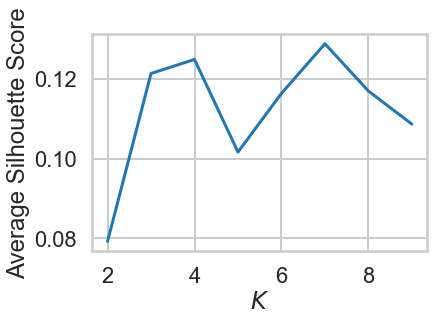

In [14]:
# Computing the avrage silhouette score for each K and plotting it 
# Call plot() with parameters Krange, avg_silhouette_scores
plt.plot(Krange, avg_silhouette_scores)
plt.xlabel("$K$")
plt.ylabel("Average Silhouette Score");

##### __What can you conclude from the Silhouette analysis?__
The silhouette plots above display a measure of how close each point in one cluster is to points in the neighboring clusters. This measure has a range of $[-1, 1]$. Silhouette coefficients or Silhouette scores with value about +1 indicate that the data in a cluster is far away from the neighboring clusters. Average values of the Silhouette coefficient across different $K$, as shown in the above plots, are far less than $1$ with maximum value being about $0.129$ for $K = 7$. This implies that there is no substantial cluster structure can be found for this dataset (please refer to the table given above under section `3aii. Choosing K: The Silhouette Method`). The finding here is again consistent with what we noted earlier for PCA-based cluster plot and the plot of sum-of-squares vs $K$ (Elbow method). In the previous cases, we have chosen $K = 3$ for which we have a Silhouette score of $0.121$ which is not very diferent from the maximum value of Silhouette score, $0.129$, obtained for $K = 7$. In other words, there is not really any distinct cluster structure. So, we can simply move on with $K = 3$ as chosen earlier. For both $K = 3$ and $K = 7$, none of the individual resulting clusters has Silhouette score above 0.5 indicating that resulting clusters are very close to each other. Some data points in a few clusters even have negative Silhouette score implying that those clusters overlap with other clusters (in other words, those data points might have been assigned to the wrong cluster).

#### 3aiii.  Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

#### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

**Hint:** See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

### 3b. Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

**Hint:** PCA was discussed in the previous subunit. If you need help with it, consult [this useful article](https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c) and [this visual explanation](http://setosa.io/ev/principal-component-analysis/). 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

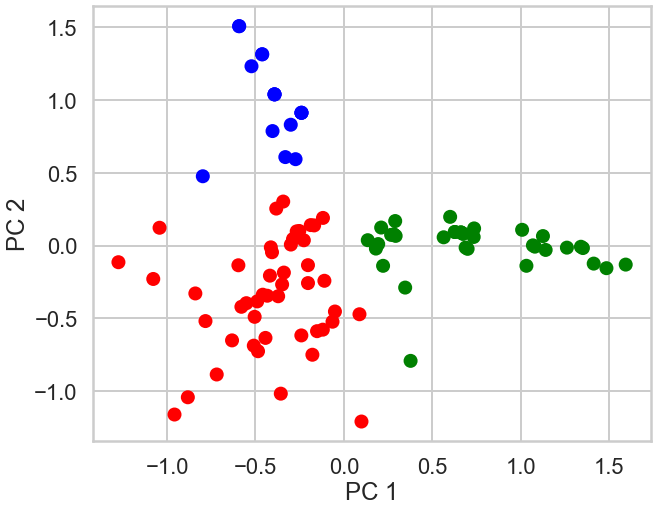

In [15]:
# Create kmeans model with n_clusters = 3 as parameter to sklearn.cluster.KMeans 
kmeans_3cluster_X = KMeans(n_clusters=3,random_state = 100)
# Call a fit_predict() on X 
labels_3cluster_X = kmeans_3cluster_X.fit_predict(X)

# Let's visualiaze with colors.ListedColormap
cmap = matplotlib.colors.ListedColormap(['red', 'green', 'blue'])

# We're going to do some PCA here. Call decomposition.PCA on sklearn, and pass n_components=2 as parameter
pc1, pc2 = zip(*pca2.fit_transform(X))
plt.figure(figsize=(10, 8))
plt.scatter(pc1, pc2, c=labels_3cluster_X.tolist(), cmap=cmap)
plt.xlabel("PC 1")
plt.ylabel("PC 2")


# Coordinates of centers of the clusters of original data
centers_X = kmeans_3cluster_X.cluster_centers_

# Projection of the above centers on the space of two dominant PCA components
centers_projecX_pca2 = centers_X @ pca2.components_.T


What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them. 

However, We can do slightly better as follows to plot more beautifully as we have done earlier at the end of Section `3ai. Choosing K: The Elbow Sum-of-Squares Method`.

Replotting here again what we already did in Line 12.



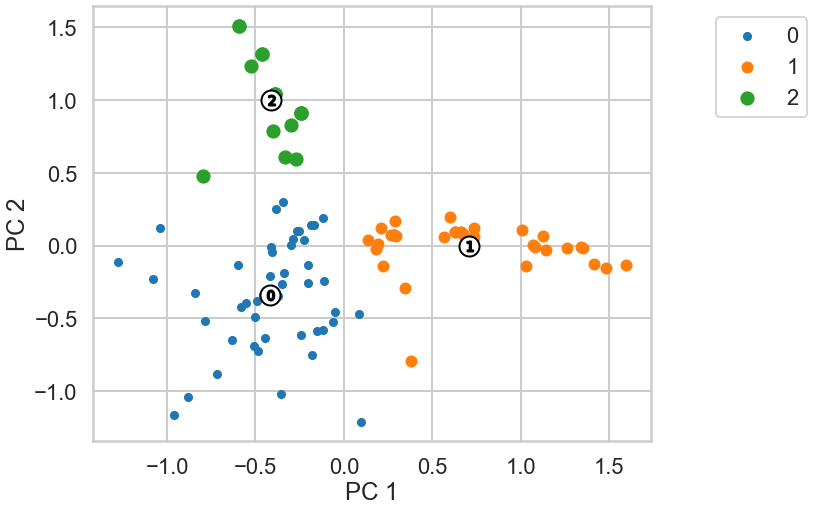

In [16]:
print('Replotting here again what we already did in Line 12.')
print()

# For PCA data (with n_components=2), create kmeans model with n_clusters = 3 as parameter to sklearn.cluster.KMeans 
kmeans_3cluster_pca2 = KMeans(n_clusters=3,random_state = 100)

#predict the labels of clusters of PCA data
labels_3cluster_pca2 = kmeans_3cluster_pca2.fit_predict(df_pca2)

#Getting unique labels
u_labels_3cluster = np.unique(labels_3cluster_pca2)
 
#plotting the results:

plt.figure(figsize=(10, 8))
for i in u_labels_3cluster:
    plt.scatter(df_pca2[labels_3cluster_pca2 == i , 0] , df_pca2[labels_3cluster_pca2 == i , 1] , s=50*(i+1), label = i)

plt.legend(bbox_to_anchor=(1, 0.8, 0.3, 0.2))


# Labeling the clusters
centers_pca2 = kmeans_3cluster_pca2.cluster_centers_
# Draw white circles at cluster centers
plt.scatter(centers_pca2[:, 0], centers_pca2[:, 1], 
            marker="o", c="white", alpha=1, s=400, edgecolor="k")

for i, c in enumerate(centers_pca2):
    plt.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=100, edgecolor="k")
    
plt.xlabel("PC 1")
plt.ylabel("PC 2")

plt.show()

In [17]:
# Checking
df_pca2[:, 0].tolist() - np.asarray(pc1)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [18]:
# Checking
df_pca2[:, 1].tolist() - np.asarray(pc2)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [19]:
# Projected centers of the clusters of the original data are different a bit because
# we are not using all the PCA components. We are only using 2 dominant PCA components.
centers_projecX_pca2, centers_pca2

(array([[-0.36539254, -0.53107722],
        [ 0.75919853, -0.1933014 ],
        [-0.36331769,  0.80930035]]),
 array([[-0.41643067, -0.33943747],
        [ 0.7081604 , -0.00166164],
        [-0.41435582,  1.00094011]]))

In [20]:
# If we use all the PCA components, then the above discrepency can be immediately resolved.
pca_full = PCA()
 
#Transform the data
df_pca = pca_full.fit_transform(X)

kmeans_3cluster_pca = KMeans(n_clusters=3,random_state = 100)

labels_3cluster_pca = kmeans_3cluster_pca.fit_predict(df_pca)

centers_projecX_pca = centers_X @ pca_full.components_.T

centers_projecX_pca[:,0:2], (centers_X @ pca_full.components_.T)[:,0:2]

(array([[-0.36539254, -0.53107722],
        [ 0.75919853, -0.1933014 ],
        [-0.36331769,  0.80930035]]),
 array([[-0.36539254, -0.53107722],
        [ 0.75919853, -0.1933014 ],
        [-0.36331769,  0.80930035]]))

Yes! They are matching.

The defintion of `lift` in y-axis of the following plots is given in the markdown below.



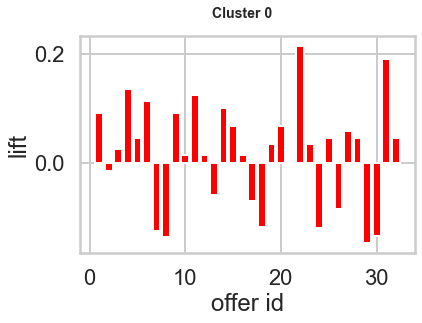

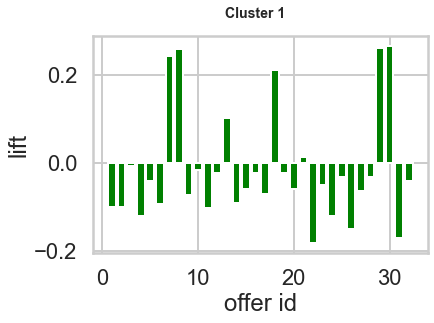

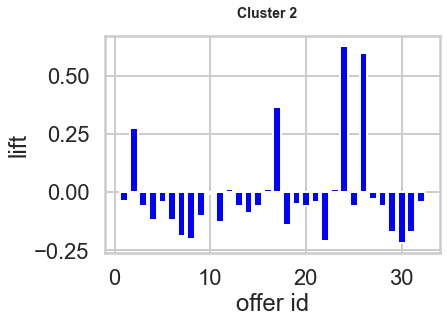

In [21]:
# Plot count of offer_id in each cluster.
# But, certain offers were used more than others in the original data.
# Let's compute the difference between how often they were used in each cluster vs globally.
# Use n_clusters=3 for illustration.

n_clusters = 3
kmeans_3cluster_X = KMeans(n_clusters=n_clusters,random_state = 100)
labels_3cluster_X = kmeans_3cluster_X.fit_predict(X)

colors = ['red', 'green', 'blue']
offer_proportions = pivoted.sum(axis=0) / pivoted.shape[0]  # There are pivoted.shape[0] = 100 customers
for i in range(n_clusters):
    plt.figure(i)
    cluster = pivoted[labels_3cluster_X == i]
    offer_proportions_cluster = cluster.sum(axis=0) / cluster.shape[0] # Number of customers in cluster
    lift = offer_proportions_cluster - offer_proportions
    plt.bar(range(1, 33), lift, color=colors[i])
    plt.suptitle((f"Cluster {i}"),fontsize=14, fontweight='bold')
    plt.xlabel('offer id')
    plt.ylabel('lift')
    
print('The defintion of `lift` in y-axis of the following plots is given in the markdown below.')
print() # print a blank line

### 3c. Remarks

#### __What do the three plots say?__

The first bar plot (shaded with red) shows a measure of relative difference how many customers accepted different offer ids in **cluster 0** with respect to how many customers from all the three clusters (globally) accepted those offers. This measure is defiend as below:

$$\mbox{lift}(i,k) = \frac{\mbox{number of customers who accepted the } i \mbox{-th offer in cluster } k}{\mbox{number of customers in cluster } k} - \frac{\mbox{number of customers who accepted the } i \mbox{-th offer over all the clusters}}{\mbox{total number of all customers}}$$

Based on this measure, we observe that customers from **cluster 0** preferred mostly Champagne, Prosecco, and Chardonnay with origin from France and Chile relative to the customers from other clusters. In particular, Champagne from France seems to be the most favorite for the customers in cluster 0. We also note that their least favorite were Prosecco from Australia, Pinot Noir, Pinot Grigio and Espumante. Another point worth mentioning is that customers from cluster 0 ordered Malbec of France enthusiastically in 1st offer (in January) but when the same offer was repeated again in December, that hardly created any interest to the customers in cluster 0.

From the second plot (shaded in green) for **cluster 1**, we notice that customers here really favored Prosecco from Australia, Espumante, Pinot Grigio, and Malbec. However, they really did not care for Champagne unlike customers in cluster 1. Another point worth mentioning is that the customers were found to order Merlot from Chile when this offer was first out in May. However, similar enthusiasm was not found among them when a similar offer was made again the following month (June). Possibly, they still were still drinking their Merlot that purchased in May.

Finally, we see that customers from **cluster 2** went exclusively for Pinot Noir regardless of its origin. They realy did not bother about any other wine variants. 

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

In [22]:
# Initialize a new PCA model with a default number of components. Then, 
# Call fit() on it, with X passed to the method, and finally create a variable 
# called variance to extract the explained variance ratio that defines the percentage
# of variance explained by each of the selected components.

# variance = pca_full.explained_variance_ratio_

# # Plot() it 
# plt.figure(figsize=(10, 8))
# plt.plot(range(len(variance)), variance)

# # Label the axes
# plt.xlabel("Number of Components")
# plt.ylabel("Proportion of Variance Explained");

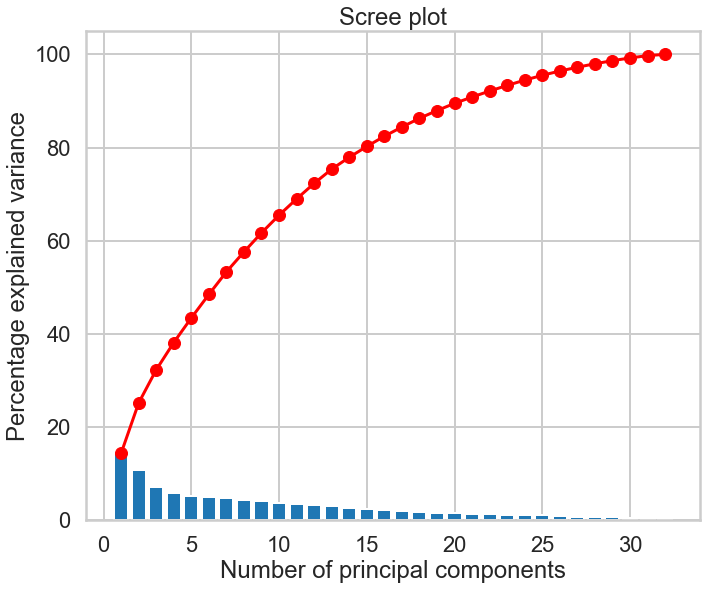


The following table displays the cumulative sum of the percentage variances of the principal components.

    Cumulative sum
0            14.39
1            25.19
2            32.29
3            38.16
4            43.43
5            48.47
6            53.32
7            57.60
8            61.69
9            65.48
10           68.97
11           72.31
12           75.36
13           77.91
14           80.23
15           82.42
16           84.40
17           86.27
18           87.93
19           89.48
20           90.85
21           92.12
22           93.33
23           94.47
24           95.50
25           96.42
26           97.23
27           97.98
28           98.65
29           99.23
30           99.73
31          100.00


In [23]:
# Display a scree plot (https://en.wikipedia.org/wiki/Scree_plot)
def display_scree_plot(pca):
    '''Display a scree plot for the pca'''

    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("Number of principal components")
    plt.ylabel("Percentage explained variance")
    plt.title("Scree plot")
    plt.show(block=False)
    print()
    print('The following table displays the cumulative sum of the percentage variances of the principal components.')
    print()
    print(pd.DataFrame(scree.cumsum().round(2), columns = ['Cumulative sum']))

plt.figure(figsize=(11, 9))
display_scree_plot(pca_full)

The blue bar plot shows the percentage variance explained by each principal component, which is derived from `explained_variance_ratio_`.  The red line shows the cumulative sum of the percentage variances.

From the scree plot, we can determine the percentage of the variance in the data explained as we successively add principal components. So, the first principal component explains 14.39% of the variance of the data set. The first 2 principal components explain 25.19%, the first 3 explain 32.29%, and so on. This shows that 14 of the 32 principal components is required to explain over 80% of the variance in the original data. In other words, we can reduce the number of variables from 32 to 14 to retain over 80% of the **variability** contained in the original data. Of course, how many principal components need to be retained for further analysis always depends specific application and project goal.

## 4. Conclusions and next steps
### 4a. Conclusions
What can you conclude from your investigations? Make a note, formulate it as clearly as possible, and be prepared to discuss it with your mentor in your next call. 

**We investigated two schemes to choose the best value of $K$ for K-Means Clustering approach. Both schemes (The Elbow Sum-of-Squares Method and The Silhouette Method) provided consistent result. The elbow method is more interpretable than the Silhouette method and also relatively easy to implement. When the principal component analysis (PCA) is used to visualize the different clusters on a 2D plot (using only the first 2 dominant principal components), the visual display of the cluster structure convey more meaningful information contained in the data. Furthher analysis of the data is also typically required to find answers to business questions.**

**In this case, we carried out further data analysis to figure out if the customers in different clusters prefer any specific wine variants or if there is any other interesting features hidden in the data. We particularly found that three different clusters correspond to specific wine variants, and origin of the wine variants also matter to a certain extent. Please see Section `3c. Remarks` for more details. This finding can certainly be used in the future to increase business revenue.**

### 4b. Other clustering algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


We would focus on them in the future in another project.